In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('tmax_train.csv')
tmax_train = df_train['tmax']
tmax_train = np.reshape(tmax_train, (-1, 1))
tmax_train.shape

(437, 1)

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
# Scaling dataset
scaled_train = scaler.fit_transform(tmax_train)
 
print(scaled_train[:5])

[[0.12852665]
 [0.13793103]
 [0.15360502]
 [0.14733542]
 [0.11912226]]


In [4]:
# Create sequences and labels for training data
# Number of time steps to look back
sequence_length = 50  
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i:i+sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)
 
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([387, 50, 1]), torch.Size([387, 50, 1]))

In [5]:
class LSTMModel(nn.Module):
      # input_size : number of features in input at each time step
      # hidden_size : Number of LSTM units 
      # num_layers : number of LSTM layers 
    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x): # defines forward pass of the neural network
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
# Define the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
batch_size = 4
# Create DataLoader for batch training
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
torch.cuda.empty_cache()
num_epochs = 50
train_hist =[]
# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
 
    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    if (epoch+1)%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}')

Epoch [10/50] - Training Loss: 0.0000
Epoch [20/50] - Training Loss: 0.0000
Epoch [30/50] - Training Loss: 0.0000
Epoch [40/50] - Training Loss: 0.0000
Epoch [50/50] - Training Loss: 0.0000


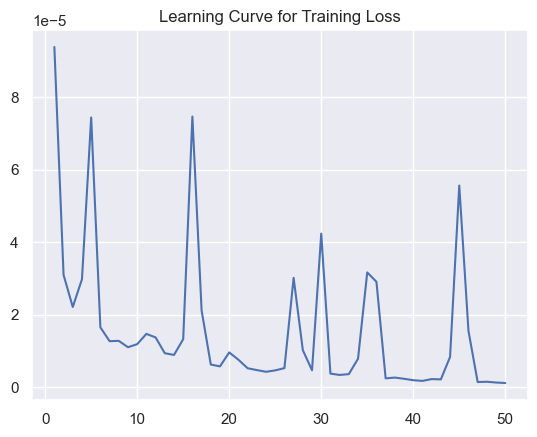

In [14]:
sns.set()
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True)
plt.title('Learning Curve for Training Loss')
plt.show()

In [15]:
torch.cuda.empty_cache()
num_days_to_predict = 30
predicted_temperatures = []

# Set initial input sequence for prediction
input_sequence = tmax_train[-sequence_length:].reshape(1, sequence_length, 1)
for _ in range(num_days_to_predict):
    with torch.no_grad():
        input_tensor = torch.FloatTensor(input_sequence).to(device)
        prediction = model(input_tensor)
        prediction = prediction.cpu().numpy()

    # Append the predicted temperature to the list
    predicted_temperatures.append(prediction[0][0])  # Assuming only one prediction value per time step

    # Update the input sequence for the next prediction
    # Assuming prediction has shape (1, 1, num_predictions)
    input_sequence = np.append(input_sequence[:, 1:, :], prediction, axis=1)

# Inverse transform the predicted temperatures to get the original scale
predicted_temperatures = scaler.inverse_transform(np.array(predicted_temperatures).reshape(-1, 1))

# Print the predicted temperatures for the next month
print('Predicted temperatures for the next month:')
for i, temp in enumerate(predicted_temperatures):
    print(f"Day {i+1}: {temp[0]}")


OutOfMemoryError: CUDA out of memory. Tried to allocate 262.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 216.03 MiB is free. Of the allocated memory 29.66 MiB is allocated by PyTorch, and 10.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Define the number of future time steps to forecast
num_forecast_steps = 30

# Initialize a list to store the forecasted values
forecasted_values = []
 
# Use the trained model to forecast future values
with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        # Prepare the historical_data tensor
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        # Use the model to predict the next value
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
 
        # Append the predicted value to the forecasted_values list
        forecasted_values.append(predicted_value[0])
 
        # Update the historical_data sequence by removing the oldest value and adding the predicted value
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
 
         
# Generate future dates
last_date = pd.to_datetime('2022-03-15', format='%Y-%m-%d')

# Generate the next 30 dates
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)
 
# Concatenate the original index with the future dates
combined_index = df_train.index.append(future_dates)
last_date

NameError: name 'historical_data' is not defined

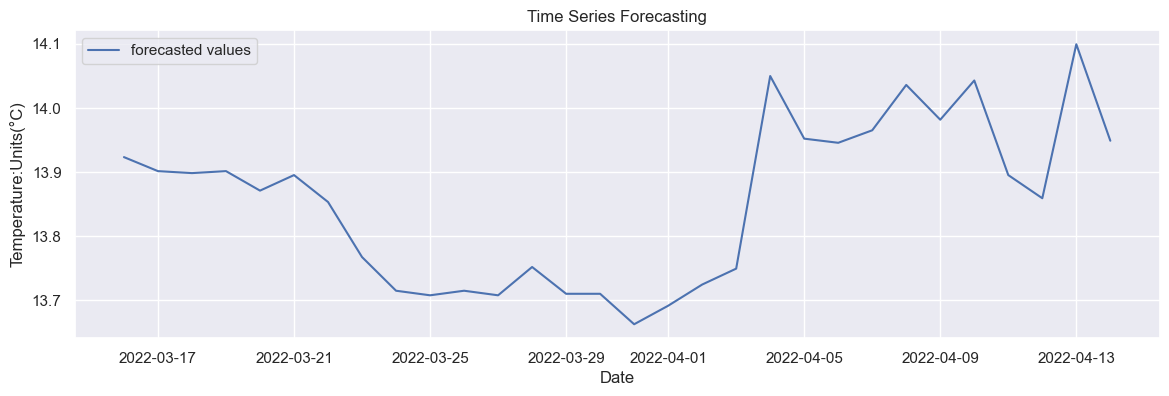

In [ ]:
# Set the size of the plot 
plt.rcParams['figure.figsize'] = [14, 4] 

# Forecasted Values 
# Reverse the scaling transformation
forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten() 

plt.plot(combined_index[-30:], forecasted_cases[-30:], label='forecasted values')  
 
plt.xlabel('Date')
plt.ylabel(r'Temperature:Units(' + chr(176) + 'C)')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)

In [ ]:
# Store the forecasted data in csv file
date = combined_index[-30:].astype(str)
date_list = []
for i in date:
    date_list.append(i.replace(' 00:00:00', ''))
    
forecasted_tmax = pd.DataFrame({'date':date_list, 'tmax': forecasted_cases[-30:]}) 
forecasted_tmax.to_csv('tmax_forecast.csv')